<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Técnicas de Modelagem de Risco de Crédito. </i>       
</p>  

# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [1]:
## Bibliotecas de Análise de Dados
import pandas as pd 
import builtins as builtins
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
import time
import datetime
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística\
import math
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from numpy import interp
import random

# Bibliotecas de Seleção de Modelos
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from lightgbm import LGBMClassifier

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score, make_scorer
import shap

# Bibliotecas de Configuração
import warnings

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='orange' style='font-size: 40px;'> Exemplo Montagem de Target </font>
<hr style='border: 2px solid orange;'>

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

> 1. Testes de Continuidade: Verificação da consistência temporal dos dados por contrato (sem quebras ou lacunas indevidas).

> 2. Criação da Coluna flag_acordo: Identificação de registros com acordos ou renegociações.

> 3. Criação da Coluna over90: Flag mensal de inadimplência grave (atraso superior a 90 dias).

> 4. Criação da Coluna mau: Identificação de contratos irrecuperáveis com base em regras de negócio.

> 5. Construção do Grupo Performing: Definição da amostra elegível para modelagem de PD, com base no status performing.

> 6. Criação da Coluna ever90m12: Indica se o contrato atingiu atraso >90 dias em qualquer mês dos próximos 12 meses (sem considerar acordos).

> 7. Criação da Coluna over90m12: Indica se o contrato está em atraso >90 dias ao final da janela futura de 12 meses (sem considerar acordos).

> 8. Criação da Coluna target: Flag final de inadimplência futura, considerando tanto atraso quanto acordos.

> 9. Congelamento do Snapshot de Contratos: Seleção de uma linha por contrato para representar o momento de avaliação (janela de decisão).

> 10. Curva de Inadimplência (over90) por Mês: Análise temporal do volume de contratos inadimplentes mês a mês (painel e snapshot).

> 11. Curvas de ever90m12 e over90m12 por Mês: Evolução mensal dos indicadores prospectivos de risco (apenas painel).

> 12. Construção da Matriz de Transição: Avaliação da migração de status de crédito entre períodos (ex: performing → inadimplente).

> 13. Construção da Curva de Cura: Medição da recuperação de contratos inadimplentes ao longo do tempo.

### 1.1.1) Entendimento de Conceitos

> 1. data_inicio_contrato

- É a data que o cliente e o banco firmaram acordo, como por exemplo 2014-09-30
- Em muitos casos, existe "carência" até o 1 vencimento, portanto, o contrato existe juridicamente mas não dá para medir performance ainda

> 2. safra:

- Mês de nascimento da performance (M0)
- Se a primeira parcela vence em jan/2025, o contrato é marcado como safra de 201501

> 3. dat_ref:

- A cada dat_ref (foto mensal), o contrato é monitorado
- A safra nunca muda, porque é o "carimbo" da geração

In [9]:
historico  = pd.read_parquet('./data/full_history.parquet')
historico['safra'] = historico.groupby('id_contrato')['data_ref'].transform('min')
historico = historico[['id_contrato','data_inicio_contrato', 'safra', 'data_ref','dias_atraso']]
historico.sort_values(by=['id_contrato','data_ref'], inplace=True)
historico['data_ref'] = pd.to_datetime(historico['data_ref'])


rastro_contratos = pd.read_parquet('./data/rastro_contratos.parquet')
rastro_contratos.sort_values(by=['id_antigo'], inplace=True)
rastro_contratos['data_evento'] = pd.to_datetime(rastro_contratos['data_evento'])
rastro_contratos.rename(columns={'id_antigo': 'id_contrato', 'data_evento': 'data_inicio_contrato'}, inplace=True)

display(historico.head(15))
display(rastro_contratos.head(15))



,id_contrato,data_inicio_contrato,safra,data_ref,dias_atraso
0,10000000,2014-09-30,2015-01-01,2015-01-01,30
1,10000000,2014-09-30,2015-01-01,2015-02-01,15
2,10000000,2014-09-30,2015-01-01,2015-03-01,15
3,10000000,2014-09-30,2015-01-01,2015-04-01,30
4,10000000,2014-09-30,2015-01-01,2015-05-01,60
5,10000000,2014-09-30,2015-01-01,2015-06-01,90
6,10000000,2014-09-30,2015-01-01,2015-07-01,60
7,10000000,2014-09-30,2015-01-01,2015-08-01,90
8,10000000,2014-09-30,2015-01-01,2015-09-01,90
9,10000000,2014-09-30,2015-01-01,2015-10-01,60


,id_contrato,id_novo,data_inicio_contrato
1023,10000000,10004583,2015-12-01
368,10000001,10003338,2015-06-01
706,10000002,10003996,2015-09-01
0,10000003,10002500,2015-02-01
255,10000007,10003118,2015-05-01
1366,10000009,10005220,2016-03-01
815,10000010,10004198,2015-10-01
55,10000011,10002680,2015-03-01
816,10000013,10004199,2015-10-01
256,10000015,10003119,2015-05-01


### 1.1.2) Flag de Renegociação   

> 1. Renegociação é quando o cliente não consegue mais horar o contrato original e o banco faz um novo acordo para tentar recuperar o crédito. Exemplo:

- O cliente estava atrasado várias parcelas
- Ao invés do banco contabilizar uma perda efetivamente, o banco oferece uma renegociação:
    - Pode reparcelar o saldo devedor em novas condições de prazos
    - Pode descontar parte da dívida
    - Pode dar carência antes de retomar os pagamentos
- Nesses casos, o ID do contrato geralmente muda e o novo ID carrega a dívida renegociada

In [10]:
historico['flag_acordo'] = 0

rastro_contratos["safra"] = np.nan
rastro_contratos["data_ref"] = np.nan
rastro_contratos["dias_atraso"] = np.nan
rastro_contratos['flag_acordo'] = 1
rastro_contratos = rastro_contratos[['id_contrato', 'data_inicio_contrato', 'safra', 'data_ref', 'dias_atraso', 'flag_acordo']]

df = pd.concat([historico, rastro_contratos])
df.sort_values(by=['id_contrato','data_ref'], inplace=True)
df = df.reset_index(drop=True)
df.head(15)

,id_contrato,data_inicio_contrato,safra,data_ref,dias_atraso,flag_acordo
0,10000000,2014-09-30,2015-01-01,2015-01-01,30.0000,0
1,10000000,2014-09-30,2015-01-01,2015-02-01,15.0000,0
2,10000000,2014-09-30,2015-01-01,2015-03-01,15.0000,0
3,10000000,2014-09-30,2015-01-01,2015-04-01,30.0000,0
4,10000000,2014-09-30,2015-01-01,2015-05-01,60.0000,0
5,10000000,2014-09-30,2015-01-01,2015-06-01,90.0000,0
6,10000000,2014-09-30,2015-01-01,2015-07-01,60.0000,0
7,10000000,2014-09-30,2015-01-01,2015-08-01,90.0000,0
8,10000000,2014-09-30,2015-01-01,2015-09-01,90.0000,0
9,10000000,2014-09-30,2015-01-01,2015-10-01,60.0000,0


### 1.1.3) Criação de Mau Origem, Over e Ever

> 1. Desconsideraremos a Flag de Acordo pois eu só conseguiria marcar Mau Origem, Over e Ever mediante a saber quantos dias de atraso o novo contrato possui

> 2. Em termos práticos:

| Tipo     | Uso         | Exemplo                                                         |
| -------- | ----------- | --------------------------------------------------------------- |
| Snapshot | Application | “Este cliente, até o mês corrente, já atrasou >30 dias?”        |
| Painel   | Behaviour   | “Este cliente, em algum momento do contrato, atrasou >30 dias?” |


In [11]:
df = pd.concat([historico, rastro_contratos])
df = df.loc[df['flag_acordo'] == 0]
df.sort_values(by=['id_contrato','data_ref'], inplace=True)
df.head(15)

# 1) Definir safra e idade em meses
df['idade_meses_contrato'] =df['data_ref'].dt.to_period('M').astype(int) - df['safra'].dt.to_period('M').astype(int)

# ==========================
# MAU_ORIGEM (exemplo: >30 dias em M0)
# ==========================

df['flag_mau_origem'] = np.where((df['dias_atraso'] >= 30) & (df['idade_meses_contrato'] == 0), 1, 0)
df['mau_origem'] = df.groupby('id_contrato')['flag_mau_origem'].transform('max')
df.drop(columns=['flag_mau_origem'], inplace=True)


# --------------------------
# EVER30M6
# --------------------------

# 1) Linha a linha → 1 apenas nas referências que bateram o limiar
df['ever30m6_snapshot'] = np.where((df['dias_atraso'] >= 30) & (df['idade_meses_contrato'] <= 6),1, 0)

# 2) Contrato inteiro → 1 se em algum mês bateu o limiar
df['ever30m6_painel'] = df.groupby('id_contrato')['ever30m6_snapshot'].transform('max')

# --------------------------
# EVER30M12
# --------------------------

# 1) Linha a linha → 1 apenas nas referências que bateram o limiar
df['ever30m12_snapshot'] = np.where((df['dias_atraso'] >= 30) & (df['idade_meses_contrato'] <= 12),1, 0)

# 2) Contrato inteiro → 1 se em algum mês bateu o limiar
df['ever30m12_painel'] = df.groupby('id_contrato')['ever30m12_snapshot'].transform('max')

df.head(15)


,id_contrato,data_inicio_contrato,safra,data_ref,dias_atraso,flag_acordo,idade_meses_contrato,mau_origem,ever30m6_snapshot,ever30m6_painel,ever30m12_snapshot,ever30m12_painel
0,10000000,2014-09-30,2015-01-01,2015-01-01,30.0000,0,0,1,1,1,1,1
1,10000000,2014-09-30,2015-01-01,2015-02-01,15.0000,0,1,1,0,1,0,1
2,10000000,2014-09-30,2015-01-01,2015-03-01,15.0000,0,2,1,0,1,0,1
3,10000000,2014-09-30,2015-01-01,2015-04-01,30.0000,0,3,1,1,1,1,1
4,10000000,2014-09-30,2015-01-01,2015-05-01,60.0000,0,4,1,1,1,1,1
5,10000000,2014-09-30,2015-01-01,2015-06-01,90.0000,0,5,1,1,1,1,1
6,10000000,2014-09-30,2015-01-01,2015-07-01,60.0000,0,6,1,1,1,1,1
7,10000000,2014-09-30,2015-01-01,2015-08-01,90.0000,0,7,1,0,1,1,1
8,10000000,2014-09-30,2015-01-01,2015-09-01,90.0000,0,8,1,0,1,1,1
9,10000000,2014-09-30,2015-01-01,2015-10-01,60.0000,0,9,1,0,1,1,1


### 1.1.4) Rolagem

In [12]:
# Curva de Performance por Safra - Cohort
bins = [0, 30, 60, 90, 120, float('inf')]
labels = ['1–30 dias','31–60 dias','61–90 dias','91–120 dias','>120 dias']
df['faixa_atraso'] = pd.cut(df['dias_atraso'], bins=bins, labels=labels, right=True)

matriz_cohort = df.groupby(['safra', 'faixa_atraso'])['id_contrato'].count().unstack(fill_value=0)
matriz_cohort_pct = matriz_cohort.div(matriz_cohort.sum(axis=1), axis=0) * 100

matriz_cohort_pct = matriz_cohort_pct.round(2)
display(matriz_cohort_pct)


# Matriz de Rolagem
bins = [0, 30, 60, 90, 120, float('inf')]
labels = ['1-30 dias','31-60 dias','61-90 dias','91-120 dias','>120 dias']
df['faixa_atraso'] = pd.cut(df['dias_atraso'], bins=bins, labels=labels, right=True)

# Ordene por contrato e data
df = df.sort_values(['id_contrato', 'data_ref'])

# Pegue a faixa de atraso do mês anterior
df['faixa_atraso_prev'] = df.groupby('id_contrato')['faixa_atraso'].shift(1)

# Considere apenas pares válidos (com mês anterior)
transicoes = df.dropna(subset=['faixa_atraso_prev', 'faixa_atraso'])

# Monte a matriz de transição
matriz_transicao = pd.crosstab(
    transicoes['faixa_atraso_prev'],
    transicoes['faixa_atraso'],
    normalize='index'
) * 100

display(matriz_transicao)

faixa_atraso,1–30 dias,31–60 dias,61–90 dias,91–120 dias,>120 dias
safra,,,,,
2015-01-01,41.7300,32.0800,16.1300,3.9700,6.1000
2015-02-01,50.6800,29.3300,14.3800,1.7800,3.8300
2015-03-01,49.2000,30.1000,15.2300,1.9600,3.5000
2015-04-01,48.6400,32.2400,14.6200,2.0800,2.4200
2015-05-01,50.8700,30.5400,14.1500,2.0600,2.3800
2015-06-01,48.2800,32.0500,14.9500,2.1500,2.5600
2015-07-01,47.4600,34.1800,13.8400,1.3700,3.1500
2015-08-01,48.4400,32.2300,13.8200,2.0000,3.5200
2015-09-01,51.7500,31.2100,13.3800,1.9000,1.7500


faixa_atraso,1-30 dias,31-60 dias,61-90 dias,91-120 dias,>120 dias
faixa_atraso_prev,,,,,
1-30 dias,84.3684,15.6316,0.0000,0.0000,0.0000
31-60 dias,9.0544,63.5413,27.4043,0.0000,0.0000
61-90 dias,0.0000,51.6292,48.3708,0.0000,0.0000
91-120 dias,0.0000,0.0000,40.2734,59.7266,0.0000
>120 dias,0.0000,0.0000,0.0000,19.6751,80.3249


# <font color='orange' style='font-size: 40px;'> Exemplo Inferência de Negados </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/code/shraddhacodes/credit-card-default-reject-inference-project

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

In [ ]:
def plot_histograms_by_flag(df, features, flag_col='FLAG_ACCEPTED', bins=20, max_cols=5):
    n = len(features)
    n_rows = math.ceil(n / max_cols)
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5*max_cols, 4*n_rows), sharey=False)
    axes = axes.flatten() if n > 1 else [axes]
    for i, feature in enumerate(features):
        for flag in sorted(df[flag_col].unique()):
            subset = df[df[flag_col] == flag][feature]
            axes[i].hist(subset.dropna(), bins=bins, alpha=1 if flag == 0 else 0.8, label=f'{flag_col}={flag}')
        axes[i].set_title(feature)
        axes[i].legend()
    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def calculate_psi_continuous(expected, actual, buckets=10):
    """Calcula o PSI para variáveis contínuas usando buckets."""
    breakpoints = np.percentile(expected.dropna(), np.linspace(0, 100, buckets + 1))
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    psi = np.sum((expected_counts - actual_counts) * np.log((expected_counts + 1e-6) / (actual_counts + 1e-6)))
    return psi

def calculate_psi_categorical(expected, actual):
    """Calcula o PSI para variáveis categóricas."""
    expected_dist = expected.value_counts(normalize=True)
    actual_dist = actual.value_counts(normalize=True)
    all_categories = set(expected_dist.index).union(set(actual_dist.index))
    psi = 0
    for cat in all_categories:
        e = expected_dist.get(cat, 1e-6)
        a = actual_dist.get(cat, 1e-6)
        psi += (e - a) * np.log((e + 1e-6) / (a + 1e-6))
    return psi

def psi(df, features, flag_col='FLAG_ACCEPTED', buckets=10, plot=True, categorical_features=None):
    psi_list = []
    group0 = df[df[flag_col] == 0]
    group1 = df[df[flag_col] == 1]
    if categorical_features is None:
        categorical_features = []
    for feature in features:
        if feature in categorical_features:
            psi_value = calculate_psi_categorical(group1[feature], group0[feature])
        else:
            psi_value = calculate_psi_continuous(group1[feature], group0[feature], buckets=buckets)
        psi_list.append({'feature': feature, 'psi': psi_value})
    psi_df = pd.DataFrame(psi_list)
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.barh(psi_df['feature'], psi_df['psi'], color='skyblue')
        plt.axvline(0.1, color='orange', linestyle='--', label='PSI = 0.1')
        plt.axvline(0.25, color='red', linestyle='--', label='PSI = 0.25')
        plt.xlabel('PSI')
        plt.title('PSI por Feature')
        plt.legend()
        plt.tight_layout()
        plt.show()

def transform_to_deciles(df, variavel_continua):
    # Calcula os limites dos deciles
    decile_limits = [i / 10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
    
    # Aplica a função qcut para transformar a variável em deciles
    deciles = pd.qcut(df[variavel_continua], q=10, labels=False, duplicates='drop')
    
    return deciles

def woe(df, feature, target):

    epsilon = 1**-50  # Pequeno valor para evitar log(0)

    risk_transaction = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'risk_transaction'}, axis = 1)
    sem_risk_transaction = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'sem_risk_transaction'}, axis = 1)

    woe = risk_transaction.merge(sem_risk_transaction, on = feature, how = 'outer').fillna(0)
    woe['percent_risk_transaction'] = woe['risk_transaction']/woe['risk_transaction'].sum()
    woe['percent_sem_risk_transaction'] = woe['sem_risk_transaction']/woe['sem_risk_transaction'].sum()
    woe['woe'] = round(np.log((woe['percent_risk_transaction'] + epsilon)/(woe['percent_sem_risk_transaction'] + epsilon)), 3)
    woe = woe[[feature, 'woe']]
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    
    weight_of_evidence = woe['woe'].unique()
    
    return woe

def fit_woe_binning(df, feature, target, q=10):
    """
    Cria os bins e calcula WoE a partir do conjunto de treino.
    Retorna o dicionário com bins e WoE.
    """
    # gera bins
    bins = pd.qcut(df[feature], q=q, duplicates='drop')
    grouped = df.groupby(bins)[target].agg(['count','sum'])
    grouped = grouped.rename(columns={'count':'total','sum':'events'})
    grouped['non_events'] = grouped['total'] - grouped['events']
    grouped['dist_events'] = grouped['events'] / grouped['events'].sum()
    grouped['dist_non_events'] = grouped['non_events'] / grouped['non_events'].sum()
    
    epsilon = 1e-6
    grouped['woe'] = np.log((grouped['dist_events']+epsilon)/(grouped['dist_non_events']+epsilon))
    
    # salva limites dos bins + WoE
    bin_edges = bins.cat.categories
    woe_map = dict(zip(bin_edges, grouped['woe']))
    
    return bin_edges, woe_map


def apply_woe_binning(df, feature, bin_edges, woe_map):
    """
    Aplica os bins salvos e substitui a variável por WoE.
    """
    binned = pd.cut(df[feature], bins=bin_edges, include_lowest=True)
    return binned.map(woe_map)


def calc_iv(df, feature, target, q=10):
    """
    Calcula o Information Value (IV) de uma variável.
    Para numéricas aplica binning por quantis (q).
    Para categóricas usa os próprios labels.
    """
    temp = df[[feature, target]].copy()
    
    # Se variável é numérica -> cria bins
    if pd.api.types.is_numeric_dtype(temp[feature]):
        temp['bin'] = pd.qcut(temp[feature], q=q, duplicates='drop')
    else:
        temp['bin'] = temp[feature]
    
    # Tabela de frequência
    grouped = temp.groupby('bin')[target].agg(['count','sum'])
    grouped = grouped.rename(columns={'count':'total','sum':'events'})
    grouped['non_events'] = grouped['total'] - grouped['events']
    
    # Distribuições
    grouped['dist_events'] = grouped['events'] / grouped['events'].sum()
    grouped['dist_non_events'] = grouped['non_events'] / grouped['non_events'].sum()
    
    epsilon = 1e-6
    grouped['woe'] = np.log((grouped['dist_events']+epsilon)/(grouped['dist_non_events']+epsilon))
    
    # Calcula IV
    grouped['iv'] = (grouped['dist_events'] - grouped['dist_non_events']) * grouped['woe']
    iv = grouped['iv'].sum()
    
    return iv


def iv_summary(df, features, target, q=10, plot=True):
    """
    Calcula o IV de uma lista de variáveis e plota gráfico horizontal.
    """
    iv_dict = {}
    for feature in features:
        try:
            iv = calc_iv(df, feature, target, q=q)
            iv_dict[feature] = iv
        except Exception as e:
            print(f"Erro ao calcular IV para {feature}: {e}")
    
    iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV']).sort_values(by='IV', ascending=True)
    
    if plot:
        iv_df.plot(kind='barh', figsize=(14,10), legend=False)
        plt.title("Information Value por variável")
        plt.xlabel("IV")
        plt.ylabel("Features")
        plt.grid(False)
        plt.show()
    
    return iv_df

def match_scores_with_simulated_target(df_tomadores, df_nao_tomadores, 
                                       score_col, 
                                       target_col,
                                       n_bins=10, fator_adverse=1.1,
                                       random_state=42):
    np.random.seed(random_state)
    
    # --- 1. Criar bins nos tomadores ---
    df_tomadores = df_tomadores.copy()
    df_nao_tomadores = df_nao_tomadores.copy()
    
    df_tomadores['score_bin'] = pd.qcut(df_tomadores[score_col], q=n_bins, duplicates='drop')
    
    # Pegamos os limites dos bins
    bin_edges = df_tomadores['score_bin'].cat.categories
    
    # Aplica bins nos não tomadores
    df_nao_tomadores['score_bin'] = pd.cut(df_nao_tomadores[score_col], bins=bin_edges, include_lowest=True)
    
    # --- 2. Calcular %BAD real por bin nos tomadores ---
    bad_rate_bins = df_tomadores.groupby('score_bin')[target_col].mean()
    
    # --- 3. Atribuir aleatoriamente Default_sim nos não tomadores ---
    df_nao_tomadores['Default_sim'] = 0
    
    for b in bin_edges:
        idx = df_nao_tomadores['score_bin'] == b
        n = idx.sum()
        if n == 0:
            continue
        
        # %BAD ajustado pelo fator de adverse selection
        p_bad = min(bad_rate_bins[b] * fator_adverse, 0.99)
        n_bad = int(n * p_bad)
        
        # escolhe aleatoriamente quem será mau
        bad_idx = np.random.choice(df_nao_tomadores[idx].index, size=n_bad, replace=False)
        df_nao_tomadores.loc[bad_idx, 'Default_sim'] = 1
        
    return df_nao_tomadores


In [138]:
df_approved = pd.read_excel('./data/appbeh_approved.xlsx')
df_rej = pd.read_excel('./data/appbeh_rej.xlsx')

df_approved['FLAG_ACCEPTED'] = 1

df_rej['FLAG_ACCEPTED'] = 0
df_rej['TGT_VAR'] = np.nan

df_full = pd.concat([df_approved, df_rej], ignore_index=True)
display(df_full['FLAG_ACCEPTED'].value_counts(normalize=True))
display(df_full['TGT_VAR'].value_counts(normalize=True))

df_full = df_full.dropna(subset=[col for col in df_full.columns if col != "TGT_VAR"])

FLAG_ACCEPTED
1   0.5251
0   0.4749
Name: proportion, dtype: float64

TGT_VAR
0.0000   0.8521
1.0000   0.1479
Name: proportion, dtype: float64

#### Análise Exploratória

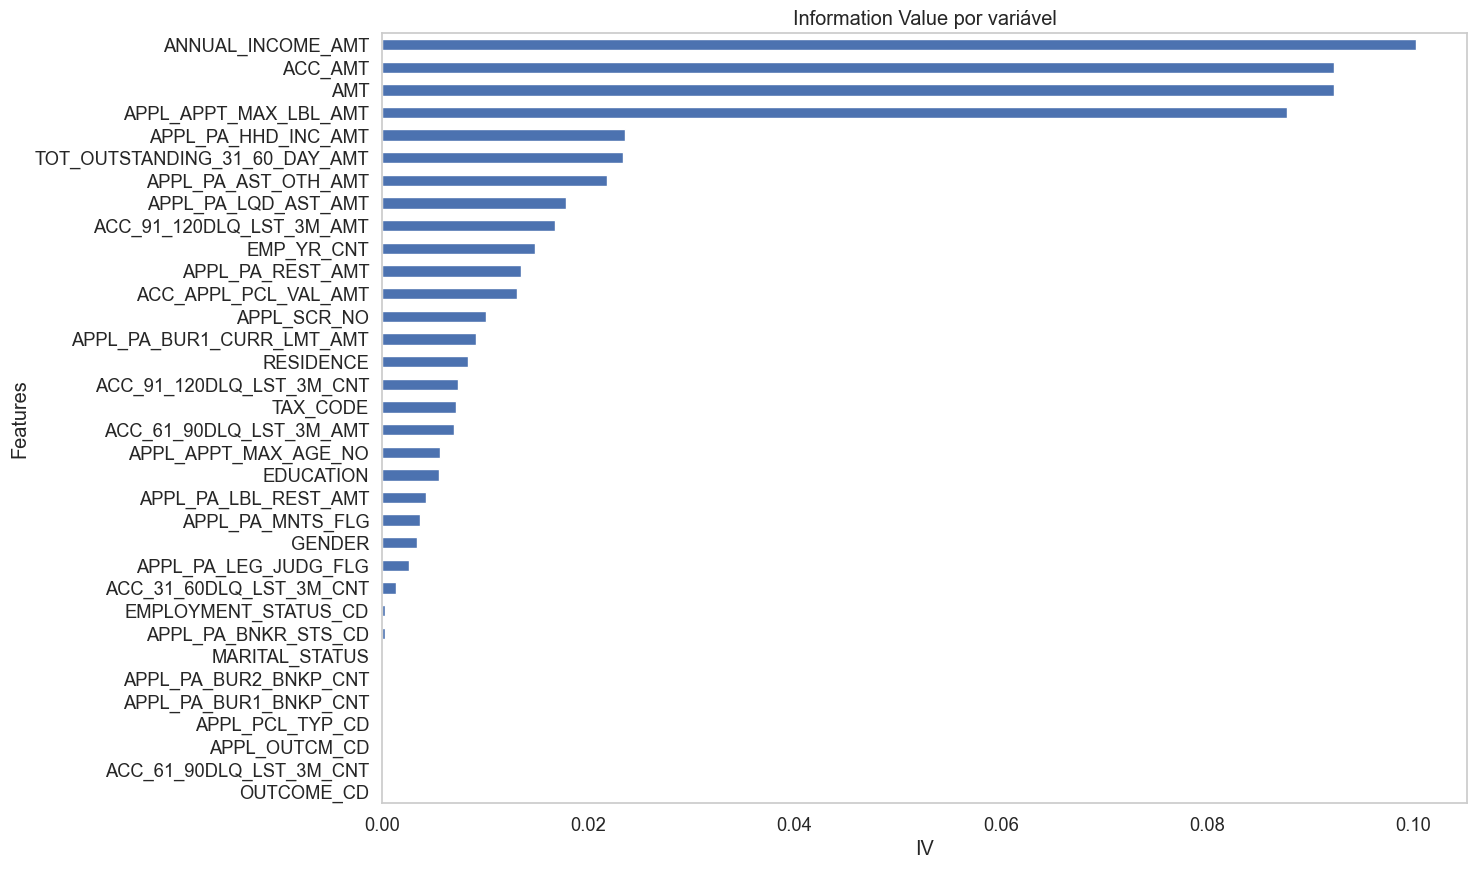

In [139]:
# Information Value
iv_df = iv_summary(df_full.loc[df_full['FLAG_ACCEPTED'] == 1], ['TAX_CODE', 'AMT', 'ACC_AMT', 'ANNUAL_INCOME_AMT', 'EDUCATION',
       'EMP_YR_CNT', 'GENDER', 'MARITAL_STATUS', 'RESIDENCE',
       'EMPLOYMENT_STATUS_CD',
       'ACC_31_60DLQ_LST_3M_CNT', 'ACC_61_90DLQ_LST_3M_CNT',
       'ACC_91_120DLQ_LST_3M_CNT',
       'TOT_OUTSTANDING_31_60_DAY_AMT',
       'ACC_61_90DLQ_LST_3M_AMT', 'OUTCOME_CD',
       'ACC_91_120DLQ_LST_3M_AMT', 'APPL_SCR_NO', 'ACC_APPL_PCL_VAL_AMT',
       'APPL_PCL_TYP_CD', 'APPL_PA_HHD_INC_AMT', 'APPL_PA_LQD_AST_AMT',
       'APPL_PA_REST_AMT', 'APPL_PA_AST_OTH_AMT', 'APPL_PA_LBL_REST_AMT',
       'APPL_PA_LEG_JUDG_FLG', 'APPL_PA_BNKR_STS_CD', 'APPL_PA_MNTS_FLG',
       'APPL_APPT_MAX_AGE_NO', 'APPL_APPT_MAX_LBL_AMT', 'APPL_OUTCM_CD',
       'APPL_PA_BUR1_BNKP_CNT', 'APPL_PA_BUR2_BNKP_CNT',
       'APPL_PA_BUR1_CURR_LMT_AMT'], target='TGT_VAR', q=10)

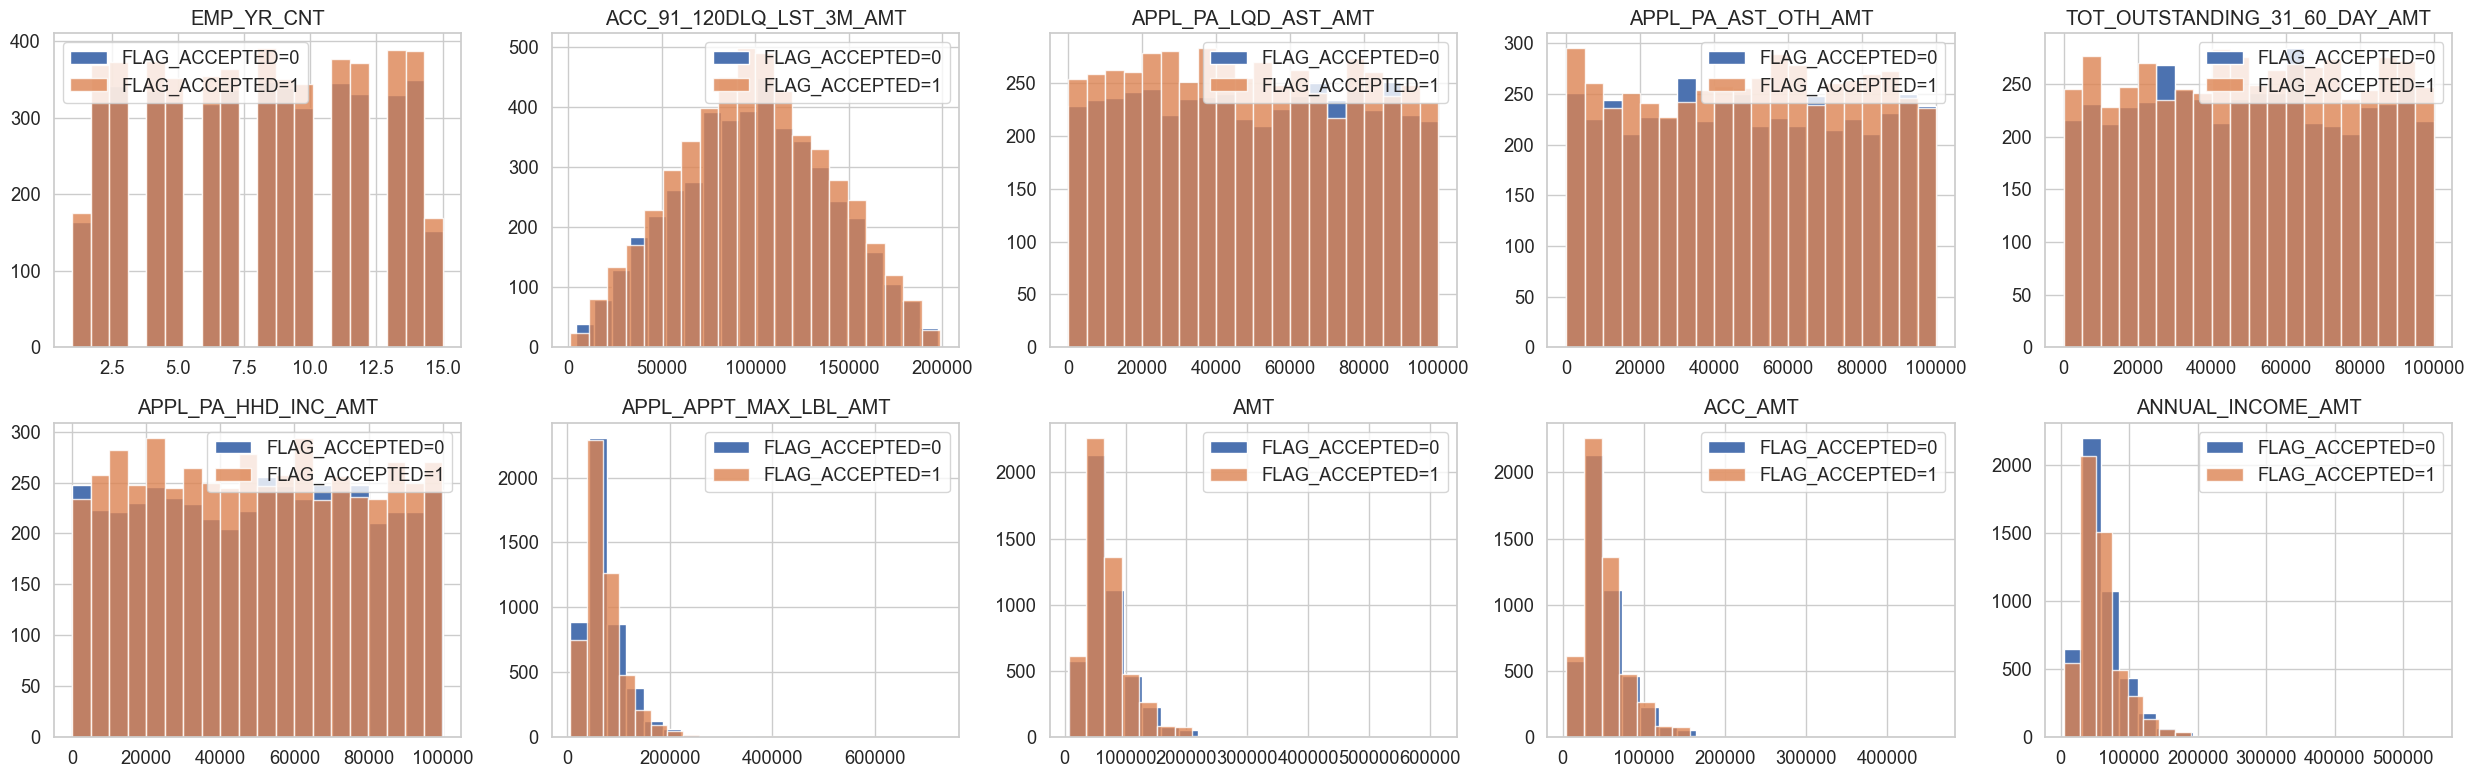

In [140]:
# Exemplo de uso:
plot_histograms_by_flag(df_full, ['EMP_YR_CNT',
'ACC_91_120DLQ_LST_3M_AMT',	
'APPL_PA_LQD_AST_AMT',	
'APPL_PA_AST_OTH_AMT',	
'TOT_OUTSTANDING_31_60_DAY_AMT',	
'APPL_PA_HHD_INC_AMT',	
'APPL_APPT_MAX_LBL_AMT',	
'AMT',	
'ACC_AMT',	
'ANNUAL_INCOME_AMT'])

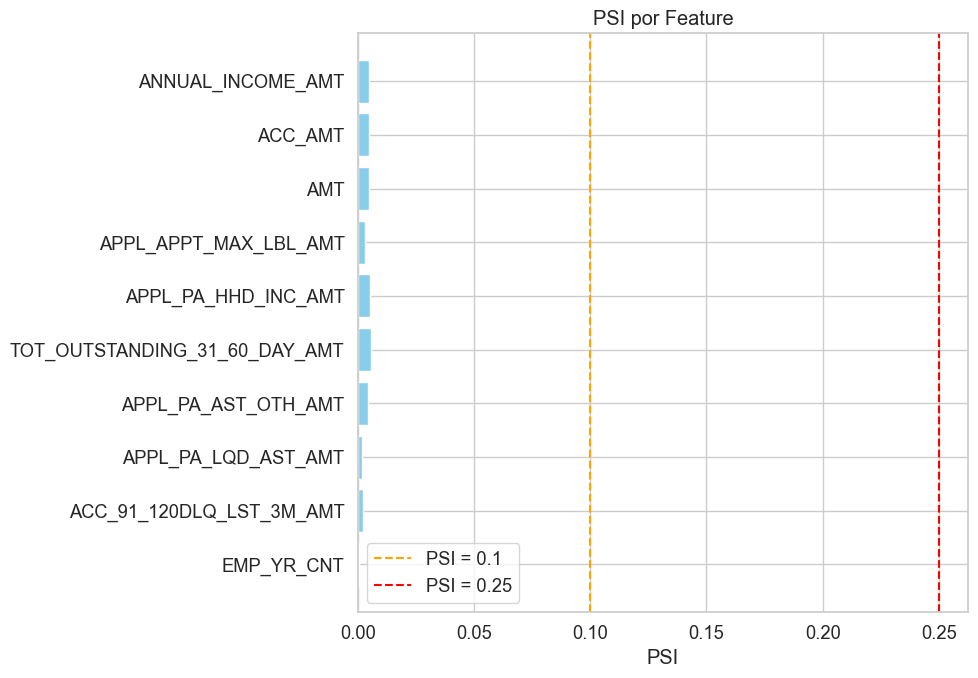

In [141]:
# Exemplo de uso:
psi(
    df_full,
    [
        'EMP_YR_CNT',
        'ACC_91_120DLQ_LST_3M_AMT',	
        'APPL_PA_LQD_AST_AMT',	
        'APPL_PA_AST_OTH_AMT',	
        'TOT_OUTSTANDING_31_60_DAY_AMT',	
        'APPL_PA_HHD_INC_AMT',	
        'APPL_APPT_MAX_LBL_AMT',	
        'AMT',	
        'ACC_AMT',	
        'ANNUAL_INCOME_AMT'
    ]
)

#### Modelagem

In [176]:
num_features = [
'ACC_91_120DLQ_LST_3M_AMT',	
'APPL_PA_LQD_AST_AMT',	
'APPL_PA_AST_OTH_AMT',	
'TOT_OUTSTANDING_31_60_DAY_AMT',	
'APPL_PA_HHD_INC_AMT',	
'APPL_APPT_MAX_LBL_AMT',	
'AMT',	
'ACC_AMT',	
'ANNUAL_INCOME_AMT']

df_full = df_full[['FLAG_ACCEPTED', 'TGT_VAR'] + num_features]

df_approved_train, df_approved_test = train_test_split(df_full.loc[df_full['FLAG_ACCEPTED'] == 1],test_size=0.3,random_state=42)

# Binning com WoE
bin_edges_dict = {}
woe_maps_dict = {}

for feature in num_features:
    # FIT no treino
    bin_edges, woe_map = fit_woe_binning(df_approved_train, feature, 'TGT_VAR', q=10)
    
    bin_edges_dict[feature] = bin_edges
    woe_maps_dict[feature] = woe_map
    
    # aplica no treino
    df_approved_train[feature] = apply_woe_binning(df_approved_train, feature, bin_edges, woe_map)
    
    # aplica no teste
    df_approved_test[feature] = apply_woe_binning(df_approved_test, feature, bin_edges, woe_map)

# Converte todas as colunas para float, categorias viram float (numéricas)
for col in df_approved_train.columns:
    df_approved_train[col] = pd.to_numeric(df_approved_train[col], errors='coerce')

for col in df_approved_test.columns:
    df_approved_test[col] = pd.to_numeric(df_approved_test[col], errors='coerce')


# Separação Target e Features
X_train=df_approved_train.drop(['FLAG_ACCEPTED', 'TGT_VAR'],axis=1)
Y_train=df_approved_train['TGT_VAR']
X_test=df_approved_test.drop(['FLAG_ACCEPTED', 'TGT_VAR'],axis=1)
Y_test=df_approved_test['TGT_VAR']


# Transformando em DataFrame
cols = list(df_approved_train.drop(['FLAG_ACCEPTED', 'TGT_VAR'], axis=1).columns)

df_approved_train = pd.DataFrame(X_train, columns=cols, index=df_approved_train.index)
df_approved_train['Default'] = Y_train
df_approved_train.fillna(0, inplace = True)

df_approved_test = pd.DataFrame(X_test, columns=cols, index=df_approved_test.index)
df_approved_test['Default'] = Y_test
df_approved_test.fillna(0, inplace = True)

# Modelagem
model = LogisticRegression(
    random_state=42, # Semente aleatória para reproducibilidade dos resultados
    class_weight={0: 1, 1: 5}, # Peso atribuído às classes. Pode ser útil para lidar com conjuntos de dados desbalanceados.
    C=500, # Parâmetro de regularização inversa. Controla a força da regularização.
    l1_ratio=0.5,
    penalty="elasticnet", # Tipo de regularização. 'l1', 'l2', 'elasticnet', ou 'none'.
    max_iter=1000, # Número máximo de iterações para a convergência do otimizador.
    solver='saga' # Algoritmo de otimização. 'newton-cg', 'lbfgs', 'liblinear' (gradiente descendente), 'sag' (Stochastic gradient descent), 'saga' (Stochastic gradient descent que suporta reg L1).
)

model.fit(X_train, Y_train)

df_approved_train['y_predict']=model.predict(df_approved_train.drop('Default', axis = 1))
df_approved_test['y_predict']=model.predict(df_approved_test.drop('Default', axis = 1))

df_approved_train['predicted_probability']=model.predict_proba(df_approved_train.drop(['Default', 'y_predict'], axis = 1))[:,1]
df_approved_test['predicted_probability']=model.predict_proba(df_approved_test.drop(['Default', 'y_predict'], axis = 1))[:,1]

# Métricas
##### Treino
accuracy_train = accuracy_score(df_approved_train['Default'], df_approved_train['y_predict'])
precision_train = precision_score(df_approved_train['Default'], df_approved_train['y_predict'])
recall_train = recall_score(df_approved_train['Default'], df_approved_train['y_predict'])
f1_train = f1_score(df_approved_train['Default'], df_approved_train['y_predict'])
roc_auc_train = roc_auc_score(df_approved_train['Default'], df_approved_train['predicted_probability'])
gini_train = 2 * roc_auc_train - 1
fpr_train, tpr_train, thresholds_train = roc_curve(df_approved_train['Default'], df_approved_train['predicted_probability'])
ks_train = max(tpr_train - fpr_train)
logloss_train = log_loss(df_approved_train['Default'], df_approved_train['predicted_probability'])

metricas = pd.DataFrame({
    'Acuracia': [accuracy_train],
    'Precisao': [precision_train],
    'Recall': [recall_train],
    'F1-Score': [f1_train],
    'Gini': [gini_train],
    'KS': [ks_train],
    'LogLoss': [logloss_train],
    'Classificador': ['LogisticRegression']
})
display(metricas)

,Acuracia,Precisao,Recall,F1-Score,Gini,KS,LogLoss,Classificador
0,0.7047,0.2224,0.4280,0.2927,0.2782,0.2110,0.6039,LogisticRegression


In [179]:
df_approved_inference = pd.concat([df_approved_train, df_approved_test])
df_rejected = df_full.loc[df_full['FLAG_ACCEPTED'] == 0]

for feature in num_features:
    # aplica nos negados
    df_rejected[feature] = apply_woe_binning(df_rejected, feature, bin_edges, woe_map)

# Converte todas as colunas para float, categorias viram float (numéricas)
for col in df_rejected.columns:
    df_rejected[col] = pd.to_numeric(df_rejected[col], errors='coerce')

df_rejected.fillna(0, inplace = True)
df_rejected['y_predict']=model.predict(df_rejected[cols])
df_rejected['predicted_probability']=model.predict_proba(df_rejected[cols])[:,1]

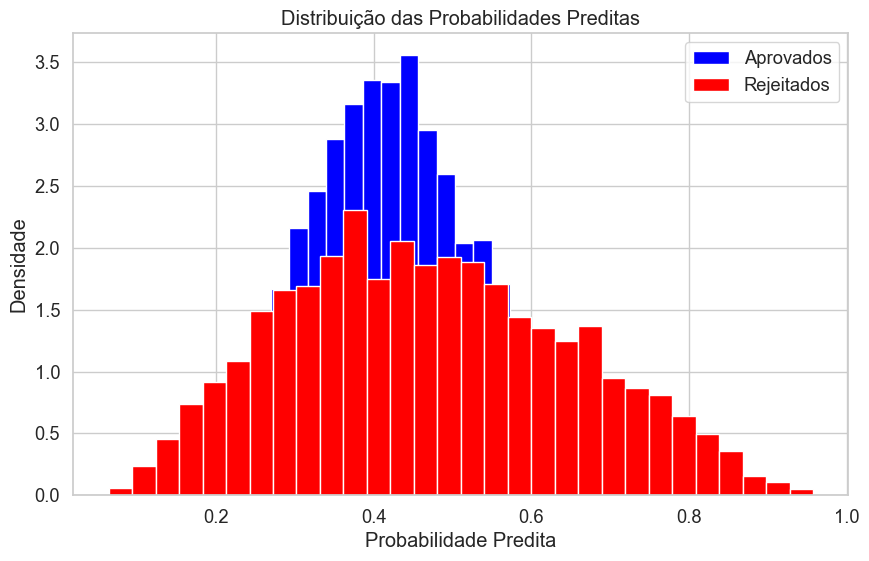

In [ ]:
plt.figure(figsize=(10,6))
# Histograma dos aprovados
plt.hist(df_approved_inference['predicted_probability'], bins=30, label='Aprovados', color='blue', density=True)

# Histograma dos rejeitados
plt.hist(df_rejected['predicted_probability'], bins=30, label='Rejeitados', color='red', density=True)

plt.xlabel('Probabilidade Predita')
plt.ylabel('Densidade')
plt.title('Distribuição das Probabilidades Preditas')
plt.legend()
plt.show()


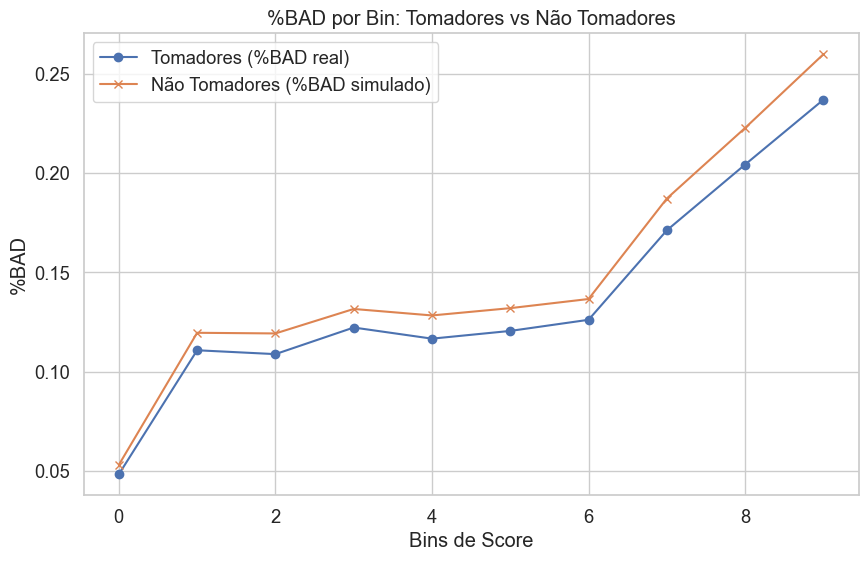

In [194]:
df_rejected_inference = match_scores_with_simulated_target(
    df_tomadores=df_approved_inference,
    df_nao_tomadores=df_rejected,
    score_col='predicted_probability',
    target_col='Default',
    n_bins=10,
    fator_adverse=1.1
)

# Cria bins nos tomadores usando a mesma lógica que a função
n_bins = 10
df_approved_inference['score_bin'] = pd.qcut(
    df_approved_inference['predicted_probability'],
    q=n_bins,
    duplicates='drop'
)

# Agora sim podemos calcular %BAD por bin
bad_rate_tomadores = df_approved_inference.groupby('score_bin')['Default'].mean()
bad_rate_rejeitados = df_rejected_inference.groupby('score_bin')['Default_sim'].mean()

plt.figure(figsize=(10,6))
plt.plot(bad_rate_tomadores.values, label='Tomadores (%BAD real)', marker='o')
plt.plot(bad_rate_rejeitados.values, label='Não Tomadores (%BAD simulado)', marker='x')
plt.xlabel('Bins de Score')
plt.ylabel('%BAD')
plt.title('%BAD por Bin: Tomadores vs Não Tomadores')
plt.legend()
plt.show()


# <font color='orange' style='font-size: 40px;'> Exemplo Análise de Sobrevivência em Risco de Crédito </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/code/jurk06/survival-analysis/notebook

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

| Variable Name                                | Description                                                                                  | Type       |
|----------------------------------------------|----------------------------------------------------------------------------------------------|------------|
| SeriousDlqin2yrs                             | Person experienced 90 days past due delinquency or worse                                     | Y/N        |
| RevolvingUtilizationOfUnsecuredLines         | Total balance on credit cards and personal lines of credit                                   | percentage |
| age                                          | Age of borrower in years                                                                     | integer    |
| NumberOfTime30-59DaysPastDueNotWorse        | Number of times borrower has been 30-59 days past due                                        | integer    |
| DebtRatio                                    | Monthly debt payments, alimony, living costs divided by monthly income                       | percentage |
| MonthlyIncome                                | Monthly income                                                                               | real       |
| NumberOfOpenCreditLinesAndLoans             | Number of open loans (installment like car loan, personal loan, mortgage)                    | integer    |
| NumberOfTimes90DaysLate                      | Number of times borrower has been 90 days or more past due                                    | integer    |
| NumberRealEstateLoansOrLines                 | Number of mortgage and real estate loans including home equity lines of credit                | integer    |
| NumberOfTime60-89DaysPastDueNotWorse        | Number of times borrower has been 60-89 days past due                                        | integer    |
| NumberOfDependents                           | Number of dependents in family excluding themselves                                          | integer    |



In [4]:
df_train = pd.read_csv('./data/cs-training.csv').drop(columns = 'Unnamed: 0')
df_test = pd.read_csv('./data/cs-test.csv').drop(columns = 'Unnamed: 0')

# Step 1: Rename
df_train.rename(columns={'SeriousDlqin2yrs': 'event'}, inplace=True)
df_train['event'] = df_train['event'].astype(int)

df_test.rename(columns={'SeriousDlqin2yrs': 'event'}, inplace=True)
# df_test['event'] = df_test['event'].astype(int)

df_train['duration'] = df_train['age']  # This is a placeholder. In real data, use time to default or observation time.
df_test['duration'] = df_test['age']  # This is a placeholder. In real data, use time to default or observation time.

# Step 2: Data preprocessing
df_train['MonthlyIncome'].fillna(df_train['MonthlyIncome'].median(), inplace=True)
df_train['NumberOfDependents'].fillna(df_train['NumberOfDependents'].median(), inplace=True) 

df_test['MonthlyIncome'].fillna(df_train['MonthlyIncome'].median(), inplace=True)
df_test['NumberOfDependents'].fillna(df_train['NumberOfDependents'].median(), inplace=True) 

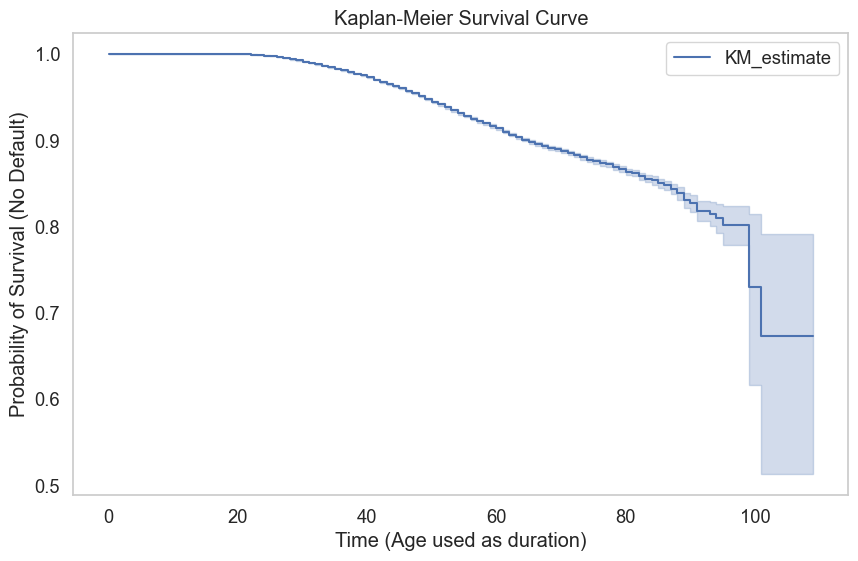

In [5]:
# Step 3: Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=df_train['duration'], event_observed=df_train['event'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (Age used as duration)")
plt.ylabel("Probability of Survival (No Default)")
plt.grid()
plt.show()

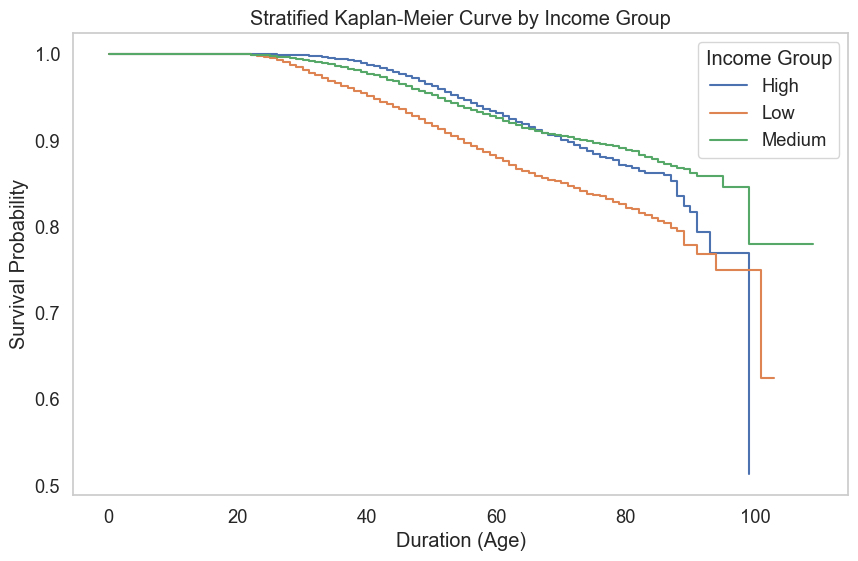

In [6]:
# Optional: create income group for stratified Kaplan-Meier
df_train['IncomeGroup'] = pd.qcut(df_train['MonthlyIncome'], 3, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(10, 6))
plt.grid()
for group in df_train['IncomeGroup'].unique():
    kmf = KaplanMeierFitter()
    mask = df_train['IncomeGroup'] == group
    kmf.fit(df_train[mask]['duration'], df_train[mask]['event'], label=str(group))
    kmf.plot_survival_function(ci_show=False)
plt.title("Stratified Kaplan-Meier Curve by Income Group")
plt.xlabel("Duration (Age)")
plt.ylabel("Survival Probability")
plt.grid()
plt.legend(title="Income Group")
plt.show()

<lifelines.CoxPHFitter: fitted with 150000 total observations, 139974 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 150000
number of events observed = 10026
   partial log-likelihood = -85830.24
         time fit was run = 2025-09-30 02:25:06 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
RevolvingUtilizationOfUnsecuredLines -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
DebtRatio                            -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
age                                  -0.69      0.50      0.01           -0.71           -0.68                0.49                0.51
NumberOfOpenCreditLinesAndLoans      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
MonthlyIncome                        -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                                      cmp to      z      p  -log2(p)
covariate                                                           
RevolvingUtilizationOfUnsecuredLines    0.00  -0.79   0.43      1.22
DebtRatio                               0.00  -3.62 <0.005     11.75
age                                     0.00 -99.43 <0.005       inf
NumberOfOpenCreditLinesAndLoans         0.00  -3.42 <0.005     10.62
MonthlyIncome                           0.00 -12.21 <0.005    111.48
---
Concordance = 0.99
Partial AIC = 171670.48
log-likelihood ratio test = 55270.25 on 5 df
-log2(p) of ll-ratio test = inf

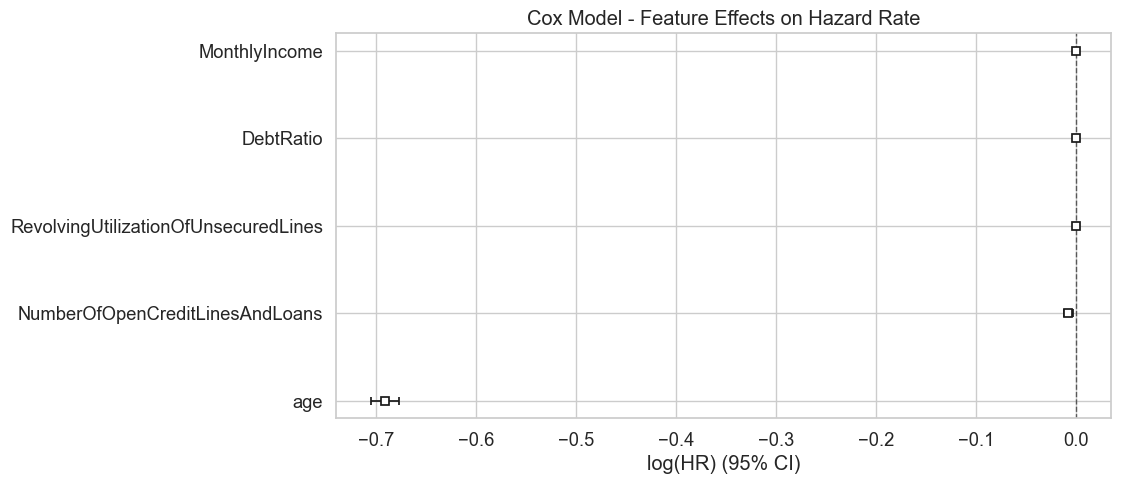

In [7]:
# Step 4: Cox Model on Train Set
features = ['duration', 'event', 'RevolvingUtilizationOfUnsecuredLines',
            'DebtRatio', 'age', 'NumberOfOpenCreditLinesAndLoans', 'MonthlyIncome']

cph = CoxPHFitter()
cph.fit(df_train[features], duration_col='duration', event_col='event')
cph.print_summary()
cph.plot()
plt.title("Cox Model - Feature Effects on Hazard Rate")
plt.show()



# <font color='orange' style='font-size: 40px;'> Exemplo Otimizador de Aprovação </font>
<hr style='border: 2px solid orange;'>

https://building.nubank.com/pt-br/ds-ml-meetup-n-o-82-do-nubank-imersao-pratica-nos-modelos-de-otimizacao/

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>